In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from performance_evaluation import plot_training_history, evaluate_model_performance

#### Read in Data
 - normalize between 0 and 1

In [3]:
train_x = pd.read_pickle('data/train_x_order_only.pkl').values
train_y = pd.read_pickle('data/train_y_order_only.pkl').values

In [4]:
test_x = pd.read_pickle('data/test_x_order_only.pkl').values
test_y = pd.read_pickle('data/test_y_order_only.pkl').values

In [5]:
train_x.shape

(135889, 759)

In [6]:
train_y.shape

(135889, 6)

# Random Numbers

In [7]:
pred_y = np.random.uniform(0,1,test_y.shape)

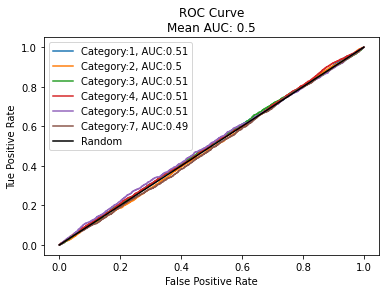

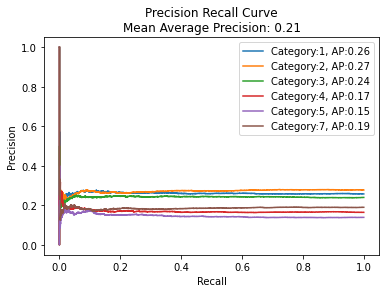

In [8]:
evaluate_model_performance(pred_y, test_y)

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

## Select Important Features

In [10]:
# Create Random Variables
random_vars = np.random.uniform(0,1,(135889,3))
train_x_random = np.hstack((train_x, random_vars))

In [11]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=10)
RF_Model.fit(train_x_random, train_y)

RandomForestClassifier(max_depth=10, n_jobs=-1)

In [12]:
from performance_evaluation import model_vars

In [13]:
model_vars_random = np.array(model_vars+['rand1', 'rand2', 'rand3'])

In [14]:
variable_importance = pd.DataFrame(
    [RF_Model.feature_importances_], columns=model_vars_random
)

#### Grab Variables with importance > Max of the 3 random variables

In [15]:
average_random_importance = variable_importance[['rand1', 'rand2', 'rand3']].T.max()[0]

In [16]:
significant_var_mask = np.argwhere(RF_Model.feature_importances_ > average_random_importance)

In [17]:
sig_var_names = model_vars_random[significant_var_mask][:,0]
sig_var_importance = RF_Model.feature_importances_[significant_var_mask][:,0]
sig_var_df = pd.DataFrame([sig_var_importance], columns = sig_var_names)
sig_var_df = sig_var_df.T.sort_values(0,ascending=False)

In [18]:
plt.rcParams["figure.figsize"] = (5,10)

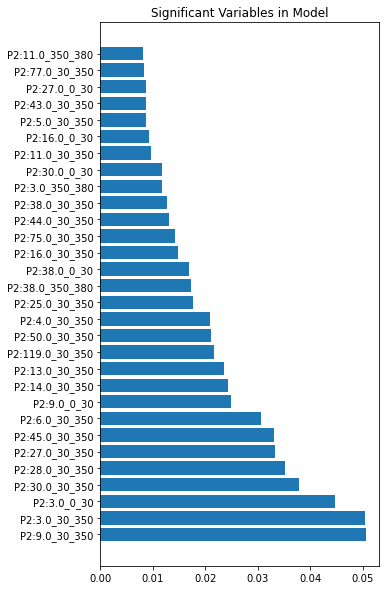

In [19]:
plt.barh(sig_var_df.index, sig_var_df[0])
plt.title('Significant Variables in Model')
plt.show()

## Train Model on Significant Features

In [20]:
sig_train_x = train_x[:,significant_var_mask[:,0]]

In [21]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=20)
RF_Model.fit(sig_train_x, train_y)

RandomForestClassifier(max_depth=20, n_jobs=-1)

In [22]:
sig_test_x = test_x[:,significant_var_mask[:,0]]

In [23]:
train_pred_y = np.array(RF_Model.predict_proba(sig_train_x))
train_pred_y = train_pred_y[:,:,1].T

In [24]:
plt.rcParams["figure.figsize"] = (5,5)

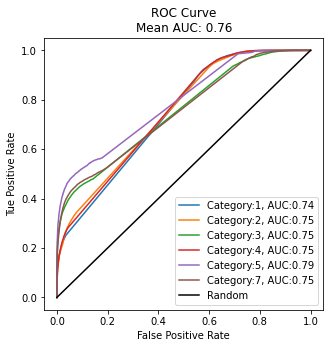

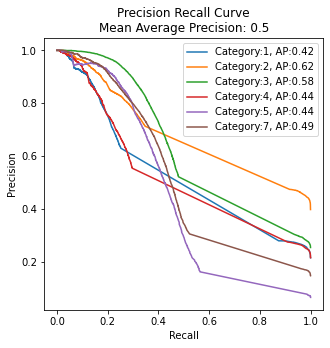

In [25]:
evaluate_model_performance(train_pred_y, train_y)

In [26]:
test_pred_y = np.array(RF_Model.predict_proba(sig_test_x))
test_pred_y = test_pred_y[:,:,1].T

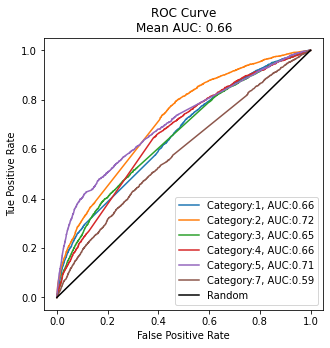

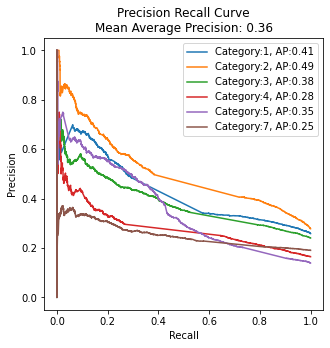

In [27]:
evaluate_model_performance(test_pred_y, test_y)

# Deep Fully Connected NN

#### Normalize for Faster Training

In [28]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

In [29]:
range_for_x_cols = np.amax(train_x, axis=0) - np.amin(train_x, axis=0)
range_for_x_cols = np.array([zero_to_ones(x) for x in range_for_x_cols])

In [30]:
norm_train_x = train_x/range_for_x_cols
norm_test_x = test_x/range_for_x_cols

# Build Model

In [31]:
def fully_connected_network(
    X, layrs, activation, last_activation, dropout, regularizer
):
    input_layer = x = keras.Input(shape=(X.shape[1],), name='Order_History')
    
    i = 0
    for layer in layrs:
        i+=1
        x = layers.BatchNormalization(name=f'BatchNorm{i}')(x)
        x = layers.Dense(layer, activation=activation, name=f'Dense{i}')(x)
        x = layers.Dropout(dropout, name=f'Dropout{i}')(x)
    
    outputs = layers.Dense(6, activation=last_activation)(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name="Fully_Connected_Model")
    return model

In [32]:
fc_layers = [759, 400, 200, 100, 50, 25, 10]

In [33]:
model = fully_connected_network(norm_train_x, fc_layers, 'elu', 'sigmoid', .5, 1)

In [34]:
model.summary()

Model: "Fully_Connected_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Order_History (InputLayer)   [(None, 759)]             0         
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 759)               3036      
_________________________________________________________________
Dense1 (Dense)               (None, 759)               576840    
_________________________________________________________________
Dropout1 (Dropout)           (None, 759)               0         
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 759)               3036      
_________________________________________________________________
Dense2 (Dense)               (None, 400)               304000    
_________________________________________________________________
Dropout2 (Dropout)           (None, 400)     

In [35]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [36]:
history = model.fit(norm_train_x, train_y, batch_size=1000, epochs=100, validation_split=0.2)

Epoch 1/100
109/109 [==============================] - 7s 62ms/step - loss: 2.2096 - accuracy: 0.2400 - val_loss: 1.8694 - val_accuracy: 0.2654
Epoch 2/100
109/109 [==============================] - 7s 63ms/step - loss: 2.0741 - accuracy: 0.3405 - val_loss: 1.9015 - val_accuracy: 0.2602
Epoch 3/100
109/109 [==============================] - 7s 65ms/step - loss: 2.0222 - accuracy: 0.3763 - val_loss: 1.9123 - val_accuracy: 0.2610
Epoch 4/100
109/109 [==============================] - 7s 61ms/step - loss: 2.0026 - accuracy: 0.3877 - val_loss: 1.8994 - val_accuracy: 0.2715
Epoch 5/100
109/109 [==============================] - 7s 60ms/step - loss: 1.9910 - accuracy: 0.3917 - val_loss: 1.8794 - val_accuracy: 0.2944
Epoch 6/100
109/109 [==============================] - 7s 65ms/step - loss: 1.9831 - accuracy: 0.3948 - val_loss: 1.8668 - val_accuracy: 0.3040
Epoch 7/100
109/109 [==============================] - 8s 71ms/step - loss: 1.9775 - accuracy: 0.3964 - val_loss: 1.8562 - val_accuracy:

109/109 [==============================] - 7s 61ms/step - loss: 1.8981 - accuracy: 0.4340 - val_loss: 1.8441 - val_accuracy: 0.2987
Epoch 58/100
109/109 [==============================] - 7s 61ms/step - loss: 1.8956 - accuracy: 0.4349 - val_loss: 1.8419 - val_accuracy: 0.3051
Epoch 59/100
109/109 [==============================] - 7s 62ms/step - loss: 1.8959 - accuracy: 0.4349 - val_loss: 1.8403 - val_accuracy: 0.2994
Epoch 60/100
109/109 [==============================] - 7s 61ms/step - loss: 1.8943 - accuracy: 0.4360 - val_loss: 1.8542 - val_accuracy: 0.2888
Epoch 61/100
109/109 [==============================] - 7s 60ms/step - loss: 1.8926 - accuracy: 0.4360 - val_loss: 1.8683 - val_accuracy: 0.2979
Epoch 62/100
109/109 [==============================] - 7s 60ms/step - loss: 1.8921 - accuracy: 0.4363 - val_loss: 1.8331 - val_accuracy: 0.3004
Epoch 63/100
109/109 [==============================] - 7s 61ms/step - loss: 1.8919 - accuracy: 0.4364 - val_loss: 1.8468 - val_accuracy: 0.298

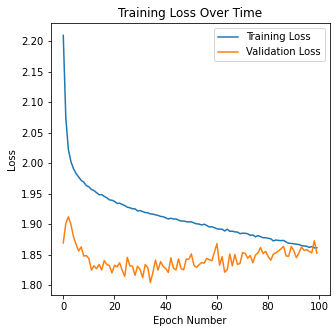

In [37]:
plot_training_history(history)

#### Training Performance

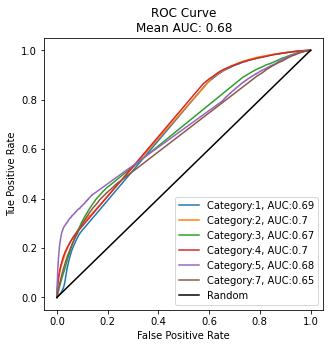

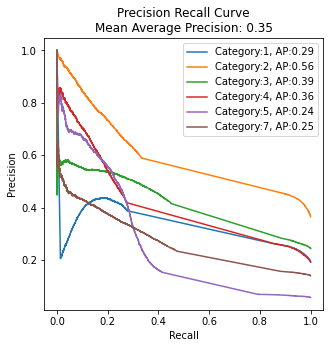

In [38]:
pred_y = model.predict(norm_train_x)
evaluate_model_performance(pred_y, train_y)

#### Test Performance

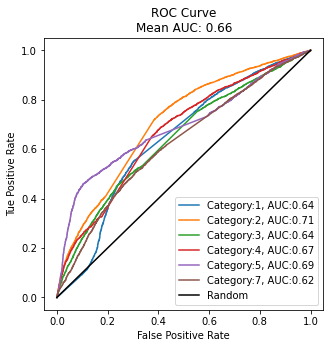

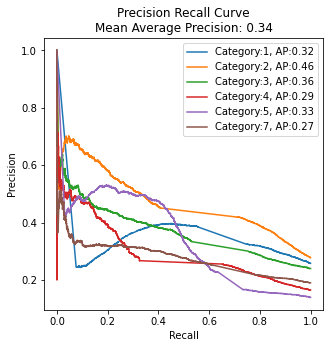

In [39]:
pred_y = model.predict(norm_test_x)
evaluate_model_performance(pred_y, test_y)